<a href="https://www.kaggle.com/code/mdmosarrofhossen/brain-tumor-detection-with-resnet50-vgg-inception?scriptVersionId=124615243" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Brain Tumor Detection

In this notebook I will include different types of solutions for brain tumor detection. The dataset is collected from [here](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection). The solutions are collected from different notebooks. As a learning process, I am collecting different solutions from different notebooks, trying to improve performace of the model and comparing the performance of the different model on this dataset.

We will use 3 models on this notebook, which are ResNet50v2, VGG19 and InceptionV3. So the contents of the notebook will be as follows,

* Importing libraries
* Loading Images and creating utility function for data augmentation
* Image demostration
* CNN models
    1. ResNet50V2
        * Training without data augmentation
        * Further tune the model with data augmentation   
    2. VGG19
        * Training without data augmentation
        * Further tune the model with data augmentation 
    3. InceptionV3
        * Training without data augmentation
        * Further tune the model with data augmentation 


Let's get started!


**NOTE: I have added a new section, which includes the testing images(test_ds). This is to check the overfitting of our models. I will try new changes to improve the performance in future updates.**

# Importing the libraries


* Numpy and pandas for data analysis
* plotlib and seaborn for data  exploration
* sklearn metrics for measuring the performance of the model
* tensorflow and keras for building our models

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

# Loading Images and creating utility function for data augmentation


In this section we will load our data(images with labels) from our dataset. The initial size(244*244) will be used for ResNet50v2, we will change the size as required for other models.

We will create two utility function for generating our data to be trained. One is image_gen, which will create train_ds and val_ds without data augmention which will be used for training the model without data augmentation. The other one is augmented_data, which will apply data_augmentation and return augmented data for train_ds which will be used to futher tune our models.

In [2]:
!apt-get install tree
# create new folders
!mkdir TRAIN TEST TRAIN/YES TRAIN/NO TEST/YES TEST/NO
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.8.0-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/YES’: File exists
mkdir: cannot create directory ‘TEST/NO’: File exists
.
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── model

7 directories


In [3]:
IMG_PATH = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    print(os.listdir(IMG_PATH))
    if not CLASS.startswith('.') and CLASS != 'brain_tumor_dataset':
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        print(IMG_NUM)
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n<5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)

['no', 'yes', 'brain_tumor_dataset']
98
['no', 'yes', 'brain_tumor_dataset']
155
['no', 'yes', 'brain_tumor_dataset']


In [4]:
dataset_dir = "/kaggle/working/TRAIN/"
test_dir = "/kaggle/working/TEST/"

In [5]:
#intializing the image size and batch size
height = 244
width = 244
batch_size=32

In [6]:
def image_gen(height, width, batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.2,
    )

    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )

    val_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="validation",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )
    
    test_gen = ImageDataGenerator(
        rescale=1./255.
    )
    
    test_ds = test_gen.flow_from_directory(
        test_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )

    return train_ds, val_ds, test_ds

    

def augmented_data(height, width):
    datagen = ImageDataGenerator(
        rescale= 1./255.,
        width_shift_range= 0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        brightness_range=(0.5, 1.0)
    )
    
    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )
    
    return train_ds

train_ds, val_ds, test_ds = image_gen(height, width)

total_images = np.concatenate([train_ds.labels, val_ds.labels, test_ds.labels])

# Print the count of images in each class
print({"No brain tumor cases": len(np.where(total_images == 0)[0]),
       "Brain tumor cases": len(np.where(total_images == 1)[0])})

Found 195 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
{'No brain tumor cases': 98, 'Brain tumor cases': 155}


# Image demostration

Demostrating some of the training data.

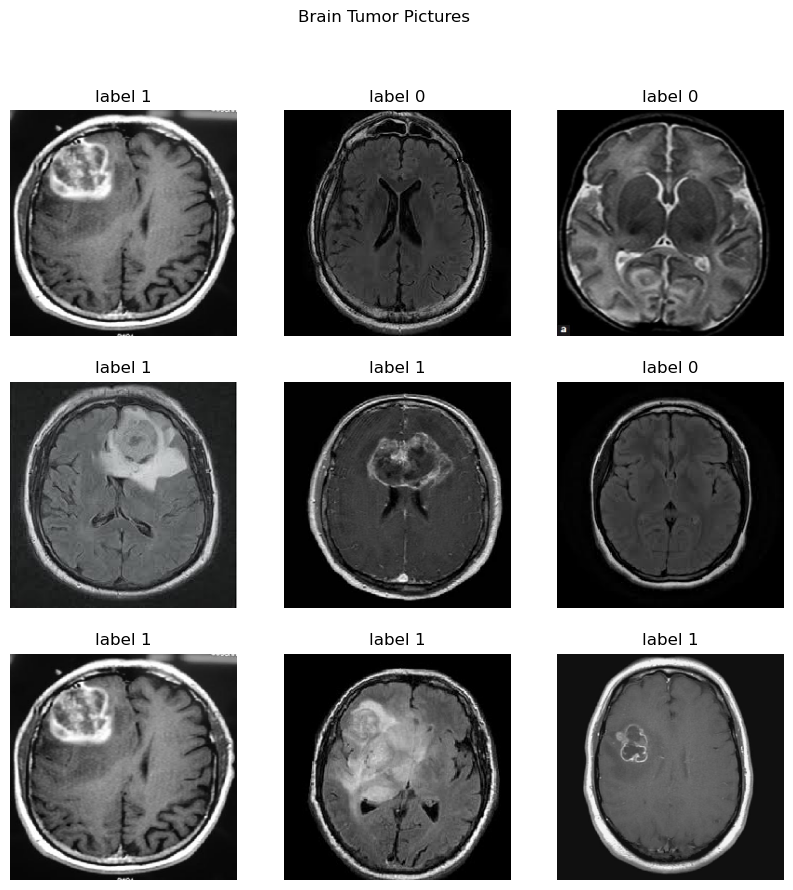

In [7]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
fig.suptitle("Brain Tumor Pictures")

for k in range(9):
    images, labels = train_ds.next()
    #print(images[0].shape)
    i, j = k//3, k%3
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"label {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()

# CNN Models

We will start training our data with the CNN models(ResNet50V2, VGG19 and InceptionV2). There will be 2 step for each cases. 

* Training without data augmentation
* Further tune the model with augmented data

# 1. ResNet50V2

We will use ResNet50V2 pre-trained model from keras. You can read more details about it from [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/ResNet50V2). We will use the pre-trained model as base model and will build a final segement with a GlobalAveragePooling2D layer, Flatten layer, 2 Dense layer and a Dropout layer. We will use softmax activation for our output layer.

**Training without data augmentation**

In [8]:
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model

In [9]:
#Declaring base model
tf.keras.backend.clear_session()

base_model = ResNet50V2(input_shape=(244,244,3), include_top=False)
base_model.trainable = False

model1 = Sequential([
    base_model, 
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model1.compile(optimizer=Adam(), 
               loss="sparse_categorical_crossentropy", 
               metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

In [10]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50v2_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model1.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 0.7582 - accuracy: 0.6513
Epoch 1: accuracy improved from -inf to 0.65128, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 8s 614ms/step - loss: 0.7582 - accuracy: 0.6513 - val_loss: 0.3189 - val_accuracy: 0.8125
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.4750 - accuracy: 0.8103
Epoch 2: accuracy improved from 0.65128 to 0.81026, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 2s 246ms/step - loss: 0.4750 - accuracy: 0.8103 - val_loss: 0.2599 - val_accuracy: 0.9167
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9077
Epoch 3: accuracy improved from 0.81026 to 0.90769, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 2s 260ms/step - loss: 0.2118 - accuracy: 0.9077 - val_loss: 0.1423 - val_accuracy: 0.9583
Epoch 4/30
7/7 [==============================] - ETA: 0s - l

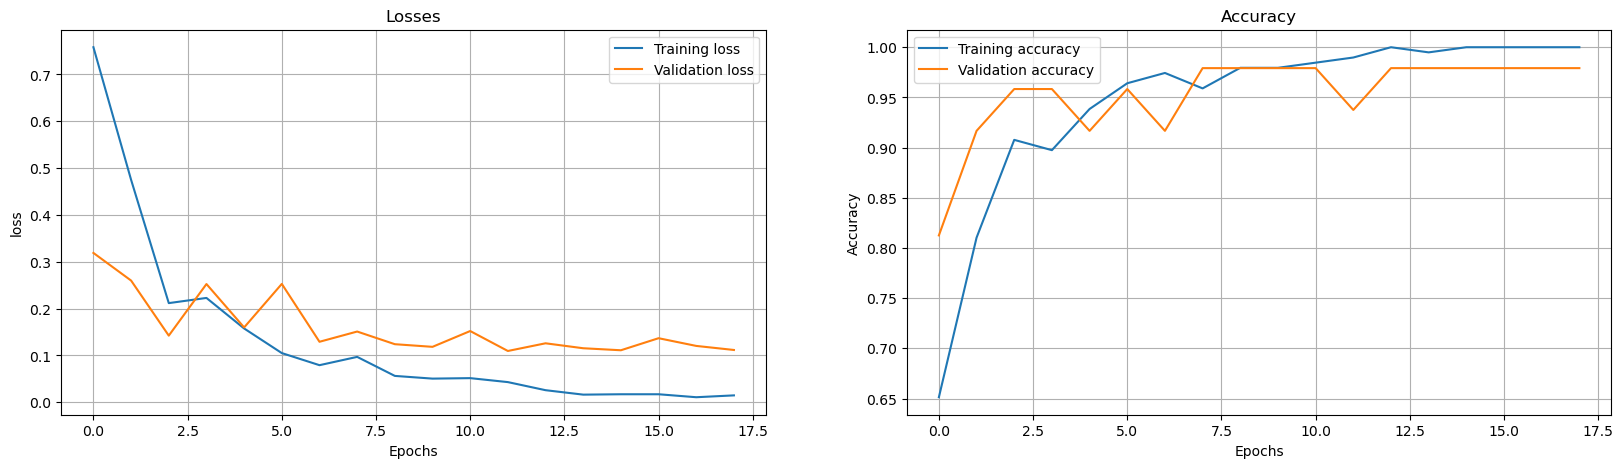

In [11]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

**Further tune the model with augmented data**

We will use our augmented_data utility function to load augmented training data. Here we are using a callback function(reduce_lr) to decrease learning rate if the accuracy doesn't improve for 2 epochs.

In [12]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                                                 patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model1.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Found 243 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.3739 - accuracy: 0.8601
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 5s 673ms/step - loss: 0.3739 - accuracy: 0.8601 - val_loss: 0.0684 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.9259
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 4s 515ms/step - loss: 0.1972 - accuracy: 0.9259 - val_loss: 0.0973 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9424
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 4s 552ms/step - loss: 0.1466 - accuracy: 0.9424 - val_loss: 0.0594 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9424
Epoch 4: accuracy did no

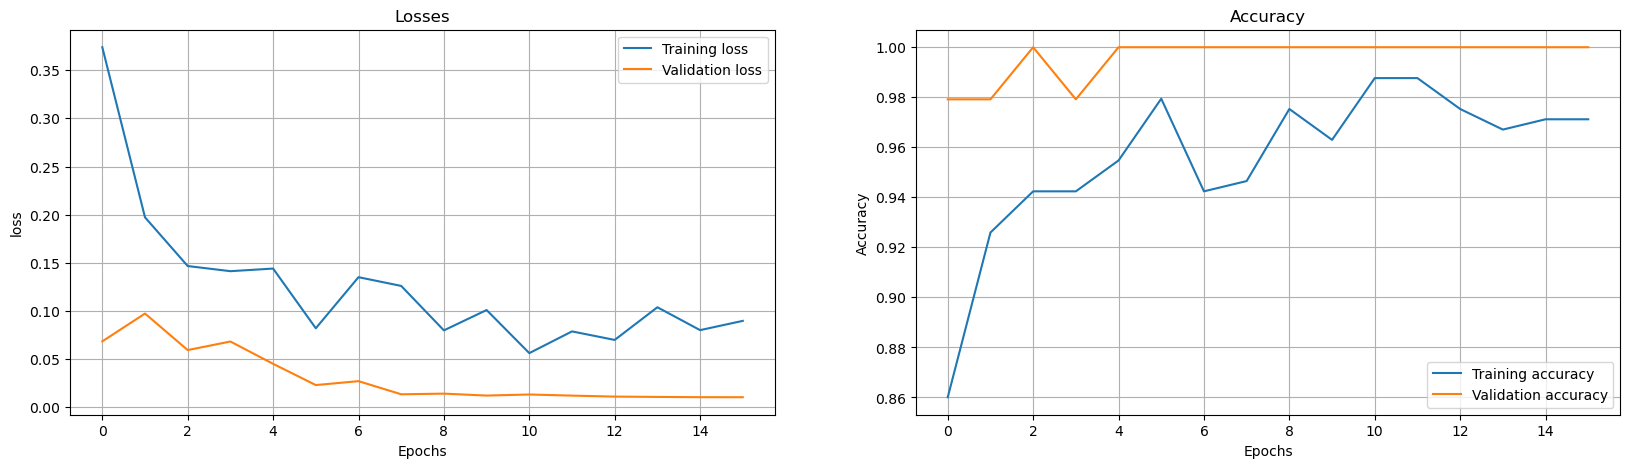

In [13]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [14]:
train_result = model1.evaluate(train_ds)
val_result = model1.evaluate(val_ds)
test_result = model1.evaluate(test_ds)

model1_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model1_result

1/1 [==============================] - 0s 318ms/step - loss: 2.0222 - accuracy: 0.6000


,Train,Validation,Testing
Loss,0.019676,0.013245,2.022175
Accuracy,1.000000,1.000000,0.600000


In [15]:
y_pred = model1.predict(test_ds[0][0])
y_pred = np.argmax(y_pred, axis=-1)

y_test = test_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

1/1 [==============================] - 1s 845ms/step
Confusion matrix:
 [[2 3]
 [1 4]]
Accuracy Score:  0.6
Classification report:
               precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.80      0.57      0.67         7

    accuracy                           0.60        10
   macro avg       0.60      0.62      0.58        10
weighted avg       0.68      0.60      0.62        10



<AxesSubplot:>

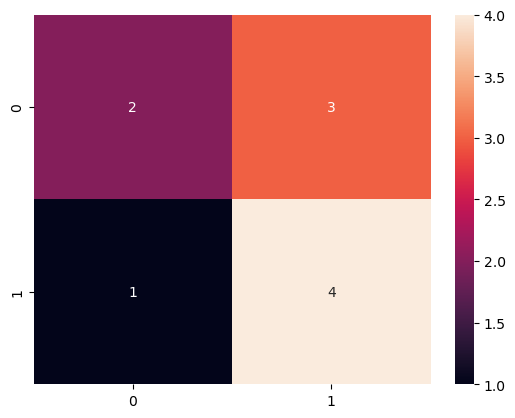

In [16]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

# 2. VGG19

We will use VGG19 pre-trained model from keras. You can read more details about it from [here](https://keras.io/api/applications/vgg/). We will use the pre-trained model as base model and will build a final segement with a Flatten layer and a Dense layer. We will use sigmoid activation for our output layer. For VGG19, we will use image size of 224*224.

**Training without data augmentation**

In [17]:
from keras.applications.vgg19 import VGG19

In [18]:
tf.keras.backend.clear_session()

#initializing new height and width for images
height=224
width=224

train_ds, val_ds, test_ds = image_gen(height, width)

base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(height,width,3)
)

base_model.trainable = False

model2 = Sequential([
    base_model,
    #GlobalAveragePooling2D(),
    Flatten(),
    #Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

model2.summary()

Found 195 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [19]:
model2.compile(loss="binary_crossentropy", 
               optimizer=Adam(0.01), metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",
                                         restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model2.fit(train_ds, 
           validation_data=val_ds,
           epochs=30,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 6.6176 - accuracy: 0.5949
Epoch 1: accuracy improved from -inf to 0.59487, saving model to model/vgg19_best.h5
7/7 [==============================] - 7s 567ms/step - loss: 6.6176 - accuracy: 0.5949 - val_loss: 2.3746 - val_accuracy: 0.7292
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 1.3715 - accuracy: 0.7949
Epoch 2: accuracy improved from 0.59487 to 0.79487, saving model to model/vgg19_best.h5
7/7 [==============================] - 1s 190ms/step - loss: 1.3715 - accuracy: 0.7949 - val_loss: 1.2645 - val_accuracy: 0.7708
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.7641 - accuracy: 0.8615
Epoch 3: accuracy improved from 0.79487 to 0.86154, saving model to model/vgg19_best.h5
7/7 [==============================] - 1s 187ms/step - loss: 0.7641 - accuracy: 0.8615 - val_loss: 0.9485 - val_accuracy: 0.7917
Epoch 4/30
7/7 [==============================] - ETA: 0s - loss: 0.4854 - a

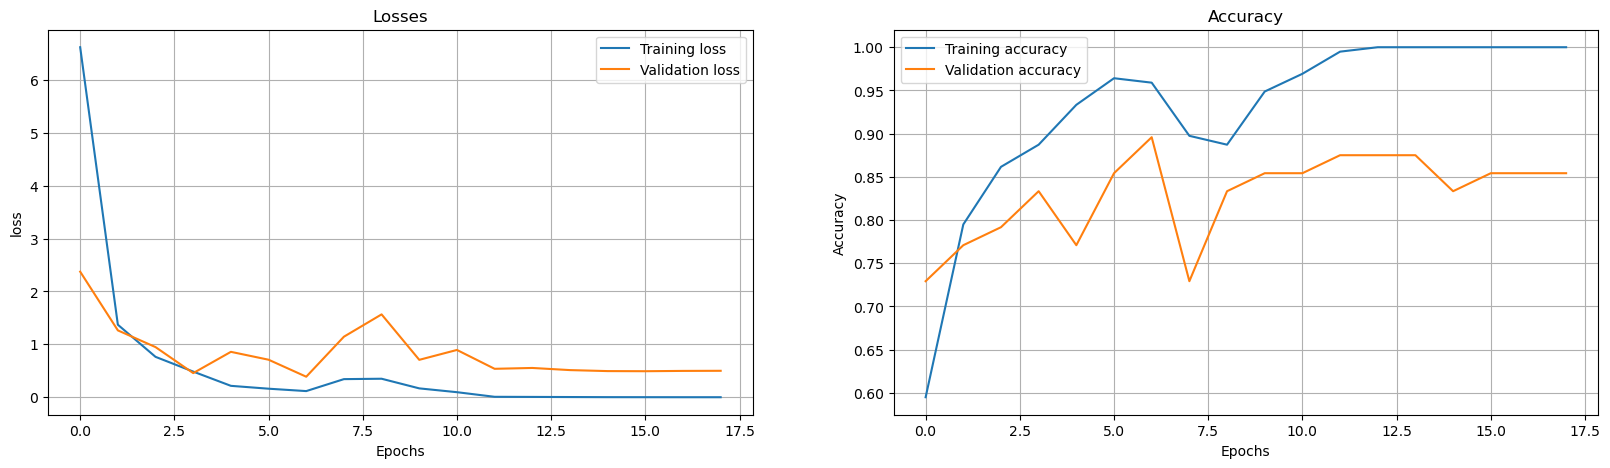

In [20]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

**Further tune the model with augmented data**

We will use our augmented_data utility function to load augmented training data. Here we are using a callback function(reduce_lr) to decrease learning rate if the accuracy doesn't improve for 2 epochs.

In [21]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.3,patience=2, 
                                                 min_lr=0.0000001)
callbacks_list = [checkpoint,early, reduce_lr]

history = model2.fit(aug_train_ds, 
           validation_data=val_ds,
           epochs=30,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

Found 243 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.8086 - accuracy: 0.8560
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 5s 456ms/step - loss: 0.8086 - accuracy: 0.8560 - val_loss: 0.5794 - val_accuracy: 0.8958 - lr: 0.0100
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.7994 - accuracy: 0.8313
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 4s 493ms/step - loss: 0.7994 - accuracy: 0.8313 - val_loss: 0.2977 - val_accuracy: 0.8958 - lr: 0.0100
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.7094 - accuracy: 0.8395
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 4s 447ms/step - loss: 0.7094 - accuracy: 0.8395 - val_loss: 0.5239 - val_accuracy: 0.9375 - lr: 0.0100
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.5951 - accuracy: 0.8148
Epoch 4: accuracy did no

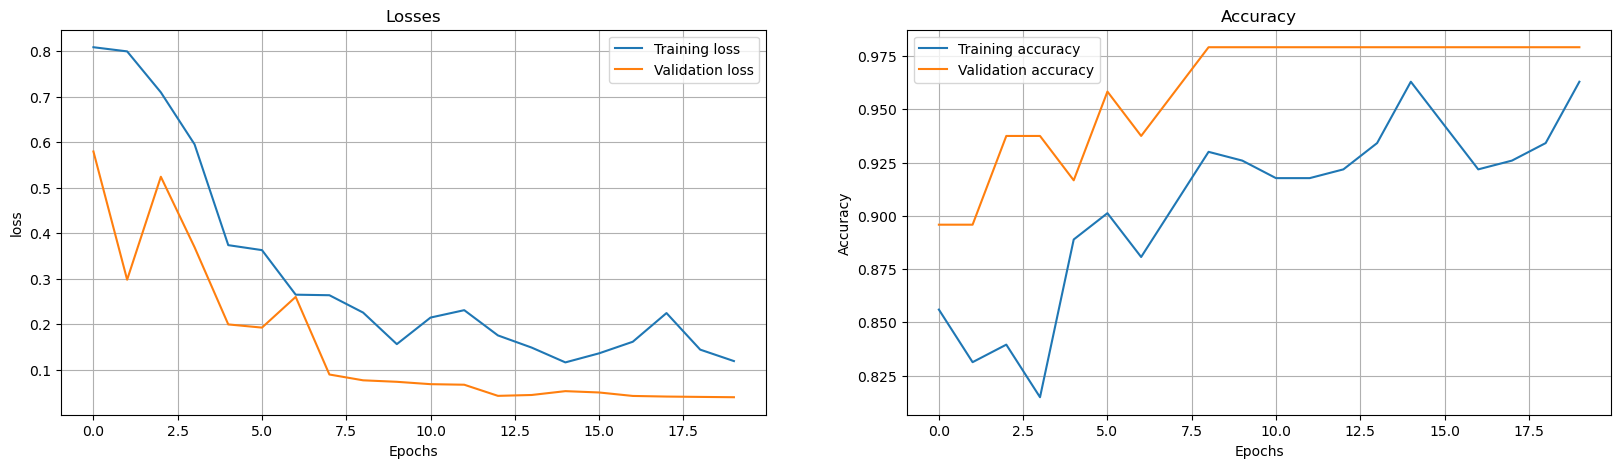

In [22]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [23]:
train_result = model2.evaluate(train_ds)
val_result = model2.evaluate(val_ds)
test_result = model2.evaluate(test_ds)

model2_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model2_result

1/1 [==============================] - 1s 1s/step - loss: 2.9988 - accuracy: 0.4000


,Train,Validation,Testing
Loss,0.005295,0.052753,2.998822
Accuracy,0.994872,0.979167,0.400000


In [24]:
y_pred = model2.predict(test_ds[0][0])
y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])

y_test = test_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

1/1 [==============================] - 0s 164ms/step
Confusion matrix:
 [[2 3]
 [3 2]]
Accuracy Score:  0.4
Classification report:
               precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.40      0.40      0.40         5

    accuracy                           0.40        10
   macro avg       0.40      0.40      0.40        10
weighted avg       0.40      0.40      0.40        10



<AxesSubplot:>

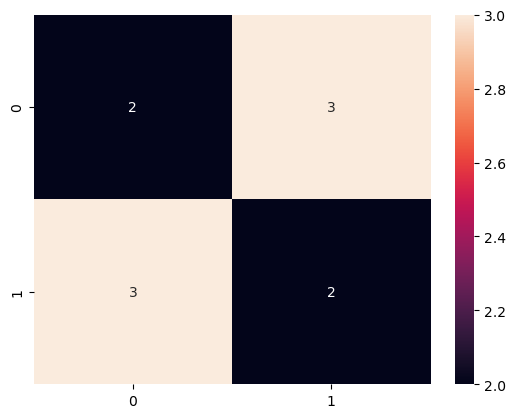

In [25]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

# 3. InceptionV3

We will use InceptionV3 pre-trained model from keras. You can read more details about it from [here](https://keras.io/api/applications/inceptionv3/). We will use the pre-trained model as base model and will build a final segement with a Flatten layer and a Dense layer. We will use sigmoid activation for our output layer.

**Training without data augmentation**

In [26]:
from keras.applications import InceptionV3

In [27]:
height=299
width=299

train_ds, val_ds, test_ds = image_gen(height, width)

tf.keras.backend.clear_session()

base_model = InceptionV3(
    input_shape=(height, width,3),
    weights='imagenet',
    include_top=False
)

base_model.trainable = False

model3 = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model3.compile(loss="binary_crossentropy", optimizer=Adam(0.01), metrics=['accuracy'])

model3.summary()

Found 195 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [28]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",
                                         restore_best_weights=True, patience=5)

callback_lsit = [checkpoint, early]

history = model3.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callback_lsit)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 32.7453 - accuracy: 0.6667
Epoch 1: accuracy improved from -inf to 0.66667, saving model to model/inceptionv3_best.h5
7/7 [==============================] - 9s 651ms/step - loss: 32.7453 - accuracy: 0.6667 - val_loss: 23.3139 - val_accuracy: 0.7708
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 10.2931 - accuracy: 0.8410
Epoch 2: accuracy improved from 0.66667 to 0.84103, saving model to model/inceptionv3_best.h5
7/7 [==============================] - 2s 329ms/step - loss: 10.2931 - accuracy: 0.8410 - val_loss: 15.4896 - val_accuracy: 0.8750
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 10.3180 - accuracy: 0.8769
Epoch 3: accuracy improved from 0.84103 to 0.87692, saving model to model/inceptionv3_best.h5
7/7 [==============================] - 2s 321ms/step - loss: 10.3180 - accuracy: 0.8769 - val_loss: 16.6938 - val_accuracy: 0.9167
Epoch 4/30
6/7 [========================>.....] -

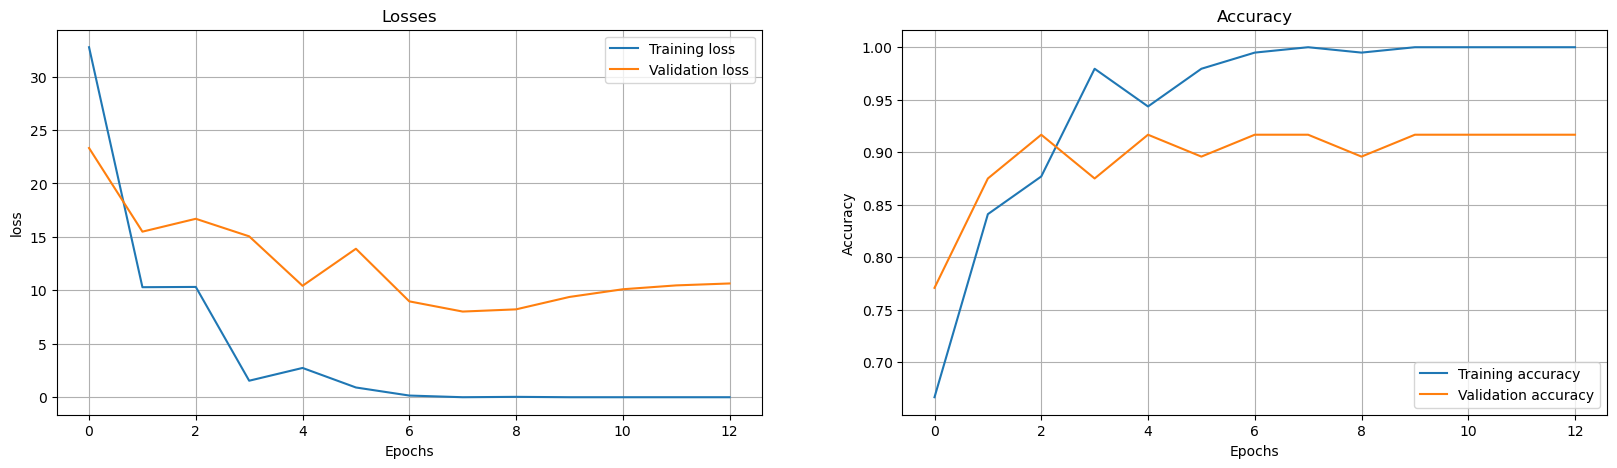

In [29]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

**Further tune the model with augmented data**

We will use our augmented_data utility function to load augmented training data. Here we are using a callback function(reduce_lr) to decrease learning rate if the accuracy doesn't improve for 3 epochs.

In [30]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                              patience=3, min_lr=0.0000001)
callback_lsit = [checkpoint, early, reduce_lr]

history = model3.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callback_lsit)

Found 243 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 12.1388 - accuracy: 0.8395
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 6s 793ms/step - loss: 12.1388 - accuracy: 0.8395 - val_loss: 7.2520 - val_accuracy: 0.9167 - lr: 0.0100
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 12.4024 - accuracy: 0.8436
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 6s 765ms/step - loss: 12.4024 - accuracy: 0.8436 - val_loss: 3.8368 - val_accuracy: 0.9583 - lr: 0.0100
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 6.3367 - accuracy: 0.8889
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 6s 748ms/step - loss: 6.3367 - accuracy: 0.8889 - val_loss: 5.0951 - val_accuracy: 0.9375 - lr: 0.0100
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 6.0851 - accuracy: 0.8848
Epoch 4: accuracy di

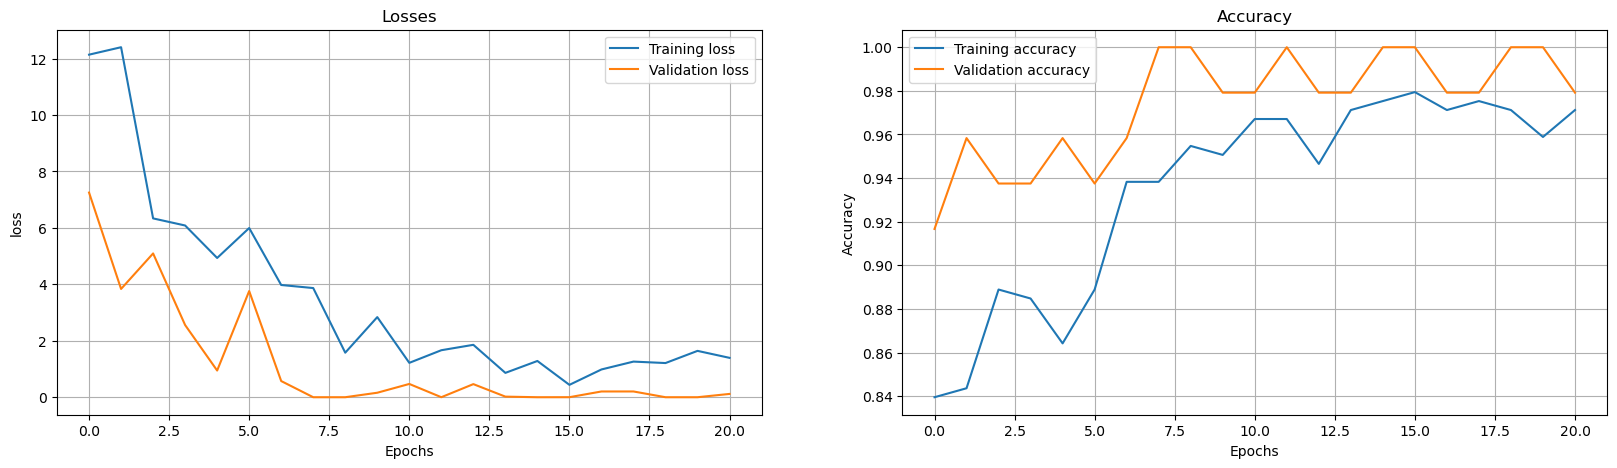

In [31]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [32]:
train_result = model3.evaluate(train_ds)
val_result = model3.evaluate(val_ds)
test_result = model3.evaluate(test_ds)

model3_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model3_result

1/1 [==============================] - 0s 451ms/step - loss: 48.8347 - accuracy: 0.7000


,Train,Validation,Testing
Loss,8.380996e-12,0.001139,48.83474
Accuracy,1.000000e+00,1.000000,0.70000


In [33]:
y_pred = model3.predict(test_ds[0][0])
y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])

y_test = test_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

1/1 [==============================] - 1s 1s/step
Confusion matrix:
 [[2 3]
 [0 5]]
Accuracy Score:  0.7
Classification report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.62      0.77         8

    accuracy                           0.70        10
   macro avg       0.70      0.81      0.67        10
weighted avg       0.88      0.70      0.73        10



<AxesSubplot:>

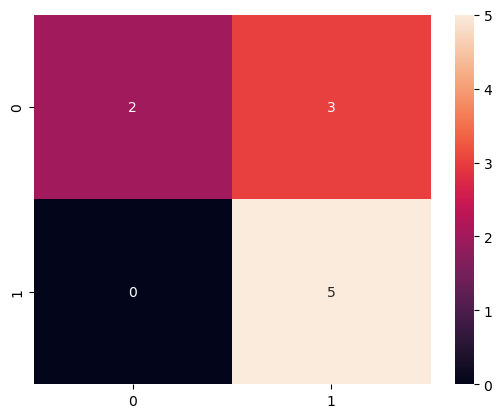

In [34]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

# Conclusion

We have a great results on our all three models. With data augmentation, we have increased the validation accuracy(val_accuray) significatly also reduced over-fitting to the training dataset. Since we had a really small dataset, the models might overfit to the train and validation data which can be reduced by adding more data. Overall we have achieved a great results.

A little comparison between the three models:


                    train_Accuracy   val_accuracy   test_accuracy

1. ResNet50V2:
                        
                         100%            ~100%         ~60%
2. VGG19:

                         99%             ~97%          ~40%          
3. InceptionV3:

                        100%            ~100%          ~70%

Please upvote if you like this notebook. Thank you!